# FORCE Learning

### Import some packages

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import backend, activations
 
print(tf.__version__)

2.5.0


In [2]:
class FORCELayer(keras.layers.AbstractRNNCell):
    def __init__(self, units, output_size, activation, seed = None, g = 1.5, 
                 input_kernel_trainable = False, recurrent_kernel_trainable = False, 
                 output_kernel_trainable = True, feedback_kernel_trainable = False, **kwargs):
      
        self.units = units 
        self.__output_size__ = output_size
        self.activation = activations.get(activation)

        if seed is None:
          self.__seed_gen__ = tf.random.Generator.from_non_deterministic_state()
        else:
          self.__seed_gen__ = tf.random.Generator.from_seed(seed)
        
        self.__g__ = g

        self.__input_kernel_trainable__ = input_kernel_trainable
        self.__recurrent_kernel_trainable__ = recurrent_kernel_trainable
        self.__feedback_kernel_trainable__ = feedback_kernel_trainable
        self.__output_kernel_trainable__ = output_kernel_trainable

        super().__init__(**kwargs)

    @property
    def state_size(self):
        return [self.units, self.units, self.output_size]

    @property 
    def output_size(self):
        return self.__output_size__

    def build(self, input_shape):

        self.input_kernel = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/input_shape[-1]**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]),
          trainable=self.__input_kernel_trainable__,
          name='input_kernel')
 
        self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer= keras.initializers.RandomNormal(mean=0., 
                                                       stddev= self.__g__/self.units**0.5, 
                                                       seed=self.__seed_gen__.uniform([1], 
                                                                                  minval=None, 
                                                                                  dtype=tf.dtypes.int64)[0]), 
          trainable=self.__recurrent_kernel_trainable__,
          name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
          shape=(self.output_size, self.units), 
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__feedback_kernel_trainable__,
          name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
          shape=(self.units, self.output_size),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/self.units**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__output_kernel_trainable__,
          name='output_kernel')      

        self.built = True

    @classmethod
    def from_weights(cls, weights, **kwargs):
        # Initialize the network from a list of weights (e.g., user-generated)
        input_kernel, recurrent_kernel, feedback_kernel, output_kernel = weights 
        input_shape, input_units = input_kernel.shape 
        recurrent_units1, recurrent_units2 = recurrent_kernel.shape 
        feedback_output_size, feedback_units = feedback_kernel.shape 
        output_units, output_size = output_kernel.shape 


        units = input_units 
        assert np.all(np.array([input_units, recurrent_units1, recurrent_units2, 
                            feedback_units, output_units]) == units)

        assert feedback_output_size == output_size 

        self = cls(units=units, output_size=output_size, **kwargs)

        self.input_kernel = self.add_weight(shape=(input_shape, self.units),
                                      initializer=keras.initializers.constant(input_kernel),
                                      trainable = self.__input_kernel_trainable__,
                                      name='input_kernel')
        
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=keras.initializers.constant(recurrent_kernel),
            trainable = self.__recurrent_kernel_trainable__,
            name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
            shape=(self.output_size, self.units),
            initializer=keras.initializers.constant(feedback_kernel),
            trainable = self.__feedback_kernel_trainable__,
            name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
            shape=(self.units, self.output_size),
            initializer=keras.initializers.constant(output_kernel),
            trainable = self.__output_kernel_trainable__,
            name='output_kernel')      

        self.built = True

        return self

class EchoStateNetwork(FORCELayer):
    def __init__(self, dtdivtau, hscale = 0.25, **kwargs):
        self.dtdivtau = dtdivtau 
        self.hscale = hscale
        super().__init__(**kwargs)        

    def call(self, inputs, states):
        """Implements the forward step (i.e., the esn() function)
        """
        prev_a, prev_h, prev_output = states      
        input_term = backend.dot(inputs, self.input_kernel)
        recurrent_term = backend.dot(prev_h, self.recurrent_kernel)
        feedback_term = backend.dot(prev_output, self.feedback_kernel)

        dadt = -prev_a + input_term + recurrent_term + feedback_term 
        a = prev_a + self.dtdivtau * dadt
        h = self.activation(a)
        output = backend.dot(h, self.output_kernel)

        return output, [a, h, output]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        initializer = keras.initializers.RandomNormal(mean=0., 
                                                      stddev= self.hscale , 
                                                      seed = self.__seed_gen__.uniform([1], 
                                                                                       minval=None, 
                                                                                       dtype=tf.dtypes.int64)[0])
        init_a = initializer((batch_size, self.units))  
        init_h =  self.activation(init_a)
        init_out = backend.dot(init_h,self.output_kernel) 
 
        return (init_a, init_h, init_out)
 


class FORCEModel(keras.Model):
    def __init__(self, force_layer, alpha_P=1.,return_sequences=True):
        super().__init__()
        self.alpha_P = alpha_P
        self.force_layer = keras.layers.RNN(force_layer, 
                                            stateful=True, 
                                            return_state=True, 
                                            return_sequences=return_sequences)

        self.units = force_layer.units 

        self.__force_layer__ = force_layer
 

    def build(self, input_shape):
        self.P_output = self.add_weight(name='P_output', shape=(self.units, self.units), 
                                 initializer=keras.initializers.Identity(
                                              gain=self.alpha_P), trainable=True)
        
        super().build(input_shape)


    def call(self, x, training=False,   **kwargs):

        if training:
            return self.force_layer(x, **kwargs) 
        else:
            initialization = all(v is None for v in self.force_layer.states)
            
            if not initialization:
              original_state = [i.numpy() for i in self.force_layer.states]
            output = self.force_layer(x, **kwargs)[0] 

            if not initialization:
              self.force_layer.reset_states(states = original_state)
            return output

    def train_step(self, data):
        # This is a standard keras method; see the Keras documentation for how this is used
        x, y = data
 

        if self.run_eagerly:
          self.hidden_activation = []
        
        for i in range(x.shape[1]):
          z, _, h, _ = self(x[:,i:i+1,:], training=True)

          if self.force_layer.return_sequences:
            z = z[:,0,:]

          # Compute pseudogradients
          trainable_vars = self.trainable_variables
          for idx in range(len(trainable_vars)):
            if 'output_kernel' in trainable_vars[idx].name:
              output_kernel_idx = idx
            elif 'P_output' in trainable_vars[idx].name:
              P_output_idx = idx

          dP = self.__pseudogradient_P(h, z, y[:,i,:])
          # Update weights
          self.optimizer.apply_gradients(zip([dP], [trainable_vars[P_output_idx]]))
          
          dwO = self.__pseudogradient_wO(h, z, y[:,i,:])
          self.optimizer.apply_gradients(zip([dwO], [trainable_vars[output_kernel_idx]]))

        # Update metrics (includes the metric that tracks the loss)
          self.compiled_metrics.update_state(y[:,i,:], z)
        # Return a dict mapping metric names to current value

          if self.run_eagerly:
            self.hidden_activation.append(h.numpy()[0])

        return {m.name: m.result() for m in self.metrics}

    def __pseudogradient_P(self, h, z, y):
        # Implements the training step i.e. the rls() function
        # This not a real gradient (does not use gradient.tape())
        # Computes the actual update
        # Example array shapes
        # h : 1 x 500
        # P : 500 x 500 
        # k : 500 x 1 
        # hPht : 1 x 1
        # dP : 500 x 500 


        k = backend.dot(self.P_output, tf.transpose(h))
        hPht = backend.dot(h, k)
        c = 1./(1.+hPht)
        assert c.shape == (1,1)
        hP = backend.dot(h, self.P_output)
        dP = backend.dot(c*k, hP)
        
        return  dP 

    def __pseudogradient_wO(self, h, z, y):
        # z : 1 x 20 
        # y : 1 x 20
        # e : 1 x 20
        # dwO : 500 x 20  

        e = z-y
        Ph = backend.dot(self.P_output, tf.transpose(h))
        dwO = backend.dot(Ph, e)

        return  dwO

    def compile(self, metrics, **kwargs):
        super().compile(optimizer=keras.optimizers.SGD(learning_rate=1), loss = 'mae', metrics=metrics,   **kwargs)

    def fit(self, x, y=None, epochs = 1, verbose = 'auto', **kwargs):

        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('Shape of x is invalid')

        if len(y.shape) < 2 or len(y.shape) > 3:
            raise ValueError('Shape of y is invalid')
        
        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)
        
        if len(y.shape) == 2:
            y = tf.expand_dims(y, axis = 0)
        
        if x.shape[0] != 1:
            raise ValueError("Dim 0 of x must be 1")

        if y.shape[0] != 1:
            raise ValueError("Dim 0 of y must be 1")
        
        if x.shape[1] != y.shape[1]: 
            raise ValueError('Timestep dimension of inputs must match')     

        return super().fit(x = x, y = y, epochs = epochs, batch_size = 1, verbose = verbose, **kwargs)

    def predict(self, x, **kwargs):
        if len(x.shape) == 3 and x.shape[0] != 1:
            raise ValueError('Dim 0 must be 1')
        
        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('')

        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)

        return self(x, training = False)[0] 


**Output as Sum of Random Sinusoids**

In [3]:
T = 1.5              # total time
u = 3               # number of inputs (didn't bother to set up zero, just put in zeros)  
n = 500             # size of the reservoir in the ESN
tau = 0.05          # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
m = 5
alpha = 1e0 # Initial learning rate for RLS
dtdivtau = dt / tau

input1 = tf.expand_dims(x_t,0)

In [4]:
def f(x, n):
    y = 0
    for i in range(n):
      tau = np.random.uniform(low=0, high=i*10+1)
      y += np.sin(tau*x)
    return y / np.max(np.abs(y),axis=0)

In [5]:
f_t = []
for i in range(m):
  f_t.append(f(time, 3*m+1))

f_t = tf.transpose(tf.convert_to_tensor(f_t,dtype=tf.float32))
input2 = np.random.multivariate_normal(mean = np.zeros(u*10), cov = np.eye(u*10), size = ntime) 

Text(0, 0.5, 'Dimension')

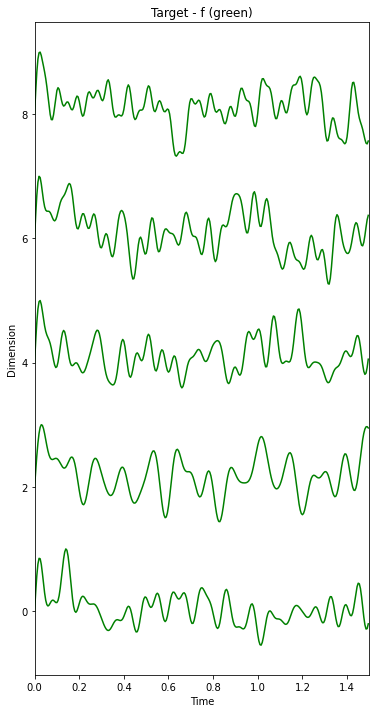

In [6]:
fig, (ax1) = plt.subplots(1, 1, sharey = True, figsize=(6,12))

ax1.plot(time , f_t  + 2*np.arange(0, f_t.shape[1]), 'g')
 
ax1.set_xlim((0, T))
plt.title('Target - f (green)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

In [7]:
myesn2 = EchoStateNetwork( dtdivtau= dtdivtau, units = n, output_size = m, activation = 'tanh', seed = 42)
model2 = FORCEModel(myesn2, return_sequences=True)  
model2.compile(metrics=["mae"] , run_eagerly = False)


history2 = model2.fit(x=input2 , y= tf.expand_dims(tf.convert_to_tensor(f_t),axis = 0) , epochs = 500)

Epoch 1/500
1/1 [==============================] - 112s 112s/step - mae: 0.0940
Epoch 2/500
1/1 [==============================] - 0s 259ms/step - mae: 0.0610
Epoch 3/500
1/1 [==============================] - 0s 270ms/step - mae: 0.0467
Epoch 4/500
1/1 [==============================] - 0s 264ms/step - mae: 0.0385
Epoch 5/500
1/1 [==============================] - 0s 278ms/step - mae: 0.0342
Epoch 6/500
1/1 [==============================] - 0s 253ms/step - mae: 0.0312
Epoch 7/500
1/1 [==============================] - 0s 273ms/step - mae: 0.0297
Epoch 8/500
1/1 [==============================] - 0s 258ms/step - mae: 0.0267
Epoch 9/500
1/1 [==============================] - 0s 265ms/step - mae: 0.0231
Epoch 10/500
1/1 [==============================] - 0s 267ms/step - mae: 0.0214
Epoch 11/500
1/1 [==============================] - 0s 259ms/step - mae: 0.0208
Epoch 12/500
1/1 [==============================] - 0s 264ms/step - mae: 0.0202
Epoch 13/500
1/1 [==============================

In [8]:
z_t_call_2 = model2.predict(input2)

In [9]:
np.mean(np.abs(z_t_call_2-f_t))

0.00461633

Text(0, 0.5, 'Dimension')

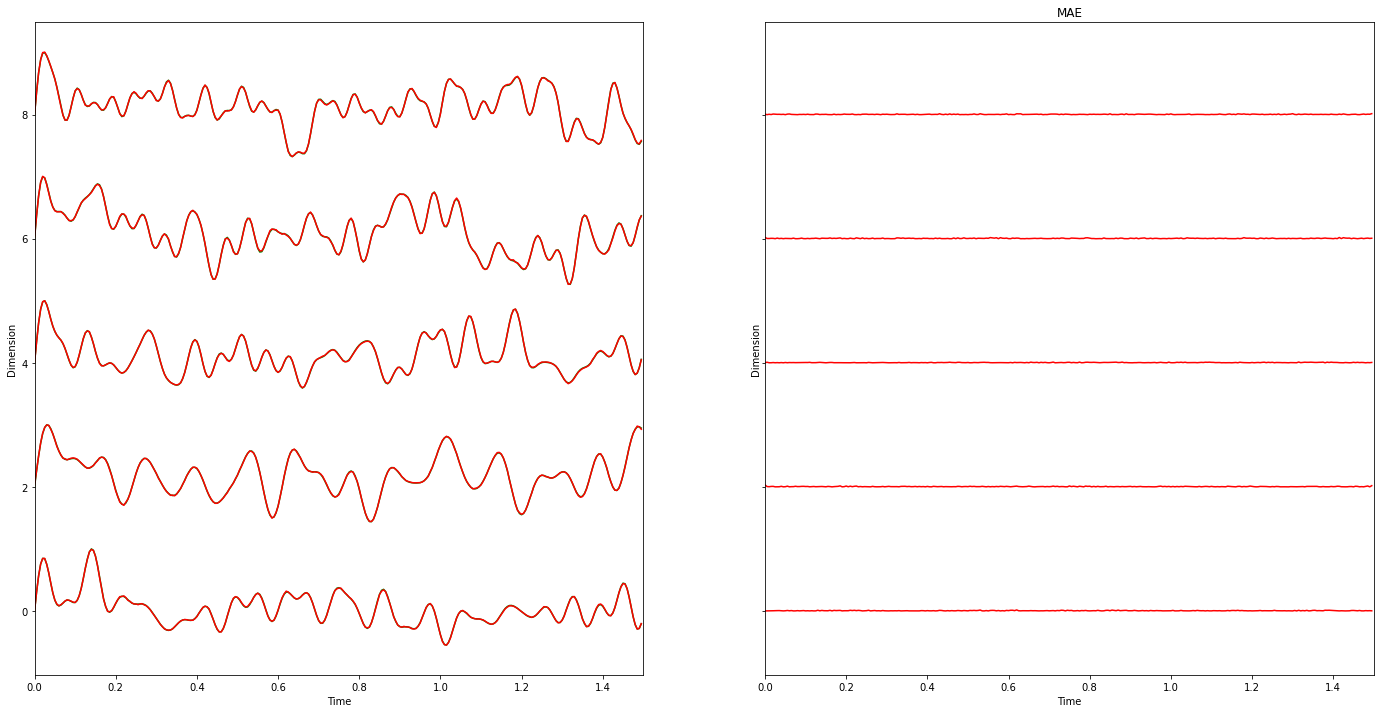

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(24,12))


ax1.plot(time , f_t  + 2*np.arange(0, f_t.shape[1]), 'g')
ax1.plot(time , z_t_call_2 + 2*np.arange(0, z_t_call_2.shape[1]), 'r');
 
ax1.set_xlim((0, T))
plt.title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(f_t-z_t_call_2) + 2*np.arange(0, z_t_call_2.shape[1]), 'r');
ax2.set_xlim((0, T))
plt.title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

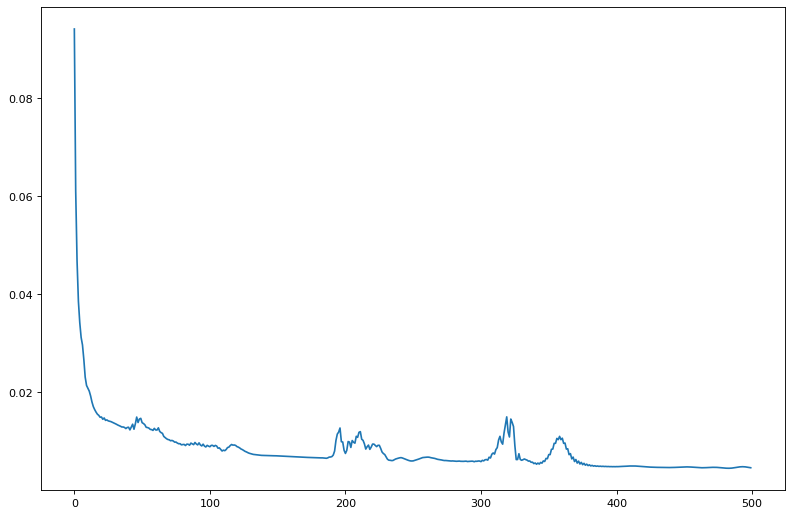

In [11]:
plt.figure(figsize=(12,8), dpi=80)
plt.plot(history2.history['mae'])

**Moving Average (Random Gaussian Input Passed Through a LPF)**

In [12]:
T = 30            # total time
u = 10               # number of inputs (didn't bother to set up zero, just put in zeros)  
n = 500             # size of the reservoir in the ESN
tau = 1.0          # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1e0 # Initial learning rate for RLS
dtdivtau = dt / tau

 

In [13]:
from scipy.signal import butter,filtfilt

cutoff = 10
fs = 30.0 
nyq = 0.5 * fs
order = 2

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

Text(0, 0.5, 'Dimension')

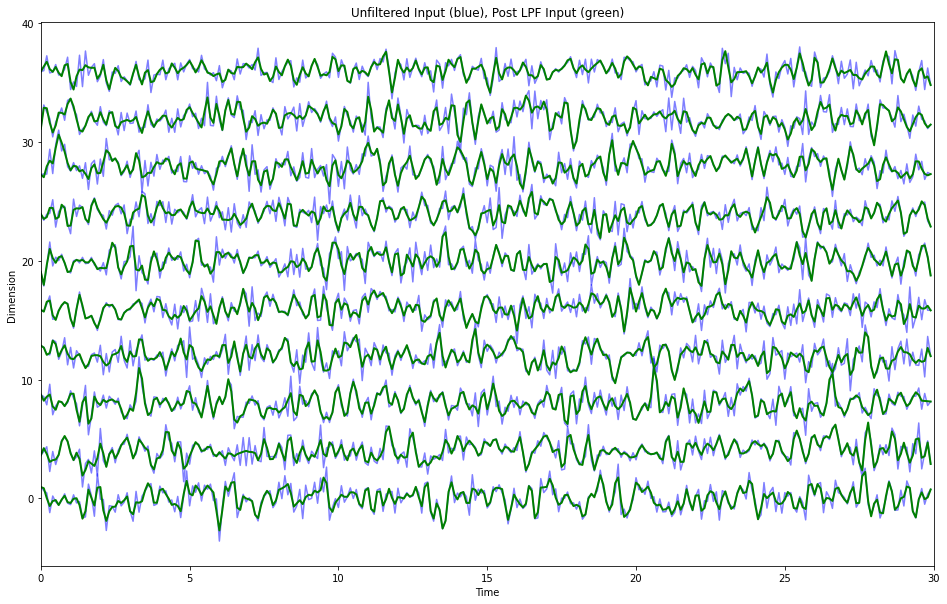

In [14]:

input3 = np.random.multivariate_normal(mean = np.zeros(u), cov = np.eye(u), size = ntime) 
input3 = np.float32(input3)
temp = input3.copy()

for i in range(input3.shape[1]):
  input3[:,i] = butter_lowpass_filter(input3[:,i], cutoff, fs, order)

plt.figure(figsize = (16,10))

plt.plot(time , temp + 4*np.arange(0, temp.shape[1]), 'b',alpha = 0.5);
plt.plot(time , input3  + 4*np.arange(0, input3.shape[1]), 'g', lw = 2) 
plt.xlim((0, T))
plt.title('Unfiltered Input (blue), Post LPF Input (green)')
plt.xlabel('Time')
plt.ylabel('Dimension')


In [15]:
out1 = input3[0:1]
for i in range(1,input3.shape[0]):
  mean = np.expand_dims(np.mean(input3[max(i-9,0):i+1], axis = 0),axis = 0)
  out1 = np.concatenate([out1,mean], axis = 0)


myesn3 = EchoStateNetwork( dtdivtau= dtdivtau, units = n, output_size = out1.shape[1], activation = 'tanh' )
model3 = FORCEModel(myesn3, return_sequences=True)  
model3.compile(metrics=["mae"] )

In [16]:
history3 = model3.fit(x=input3, y= out1, epochs =2000)

Epoch 1/2000
1/1 [==============================] - 103s 103s/step - mae: 0.0816
Epoch 2/2000
1/1 [==============================] - 0s 267ms/step - mae: 0.0552
Epoch 3/2000
1/1 [==============================] - 0s 254ms/step - mae: 0.0428
Epoch 4/2000
1/1 [==============================] - 0s 256ms/step - mae: 0.0366
Epoch 5/2000
1/1 [==============================] - 0s 266ms/step - mae: 0.0327
Epoch 6/2000
1/1 [==============================] - 0s 263ms/step - mae: 0.0310
Epoch 7/2000
1/1 [==============================] - 0s 264ms/step - mae: 0.0310
Epoch 8/2000
1/1 [==============================] - 0s 253ms/step - mae: 0.0315
Epoch 9/2000
1/1 [==============================] - 0s 253ms/step - mae: 0.0290
Epoch 10/2000
1/1 [==============================] - 0s 264ms/step - mae: 0.0274
Epoch 11/2000
1/1 [==============================] - 0s 254ms/step - mae: 0.0269
Epoch 12/2000
1/1 [==============================] - 0s 258ms/step - mae: 0.0255
Epoch 13/2000
1/1 [=================

In [17]:
z_t_call_3 = model3.predict(input3)

Text(0, 0.5, 'Dimension')

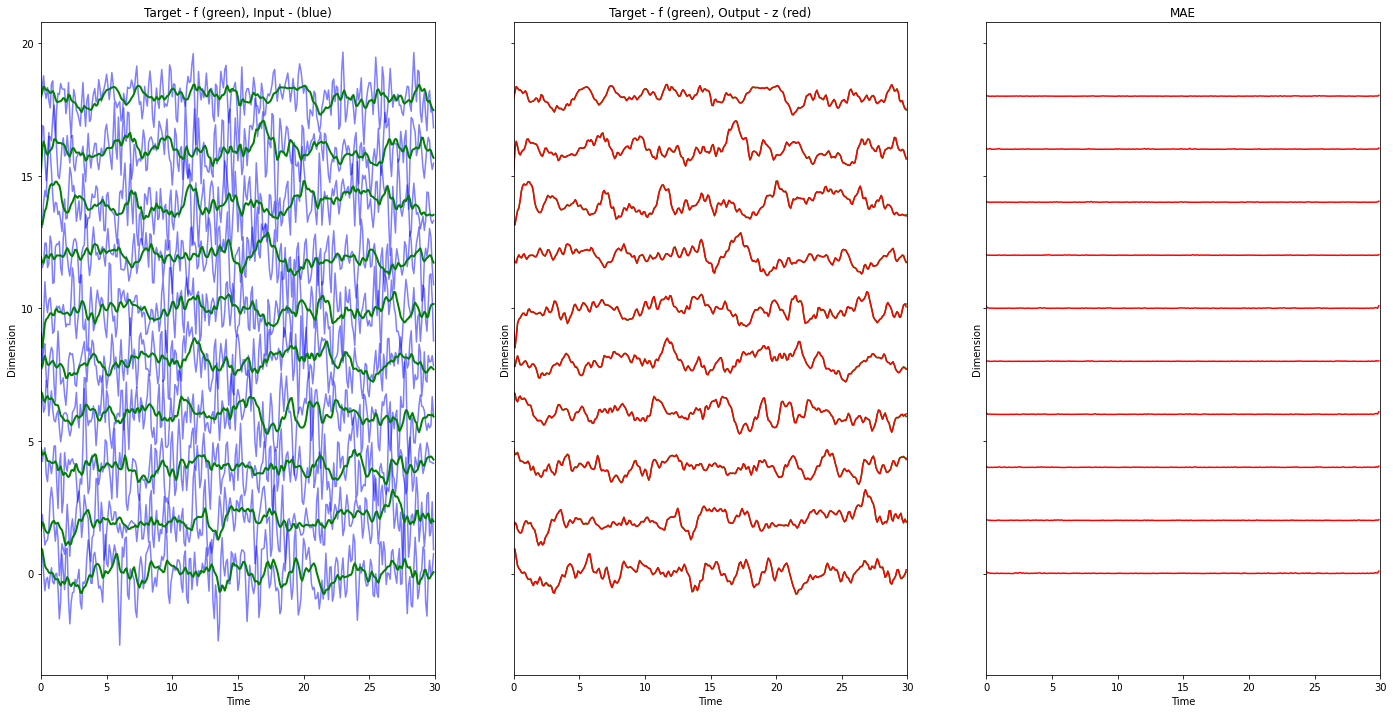

In [18]:
 fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey = True, figsize=(24,12))


ax0.plot(time , input3 + 2*np.arange(0, input3.shape[1]), 'b',alpha = 0.5);
ax0.plot(time , out1  + 2*np.arange(0, out1.shape[1]), 'g', lw = 2) 
ax0.set_xlim((0, T))
ax0.set_title('Target - f (green), Input - (blue)')
ax0.set_xlabel('Time')
ax0.set_ylabel('Dimension')


ax1.plot(time , out1  + 2*np.arange(0, out1.shape[1]), 'g')
ax1.plot(time , z_t_call_3 + 2*np.arange(0, z_t_call_3.shape[1]), 'r');
 
ax1.set_xlim((0, T))
ax1.set_title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(out1-z_t_call_3) + 2*np.arange(0, z_t_call_3.shape[1]), 'r');
ax2.set_xlim((0, T))
ax2.set_title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

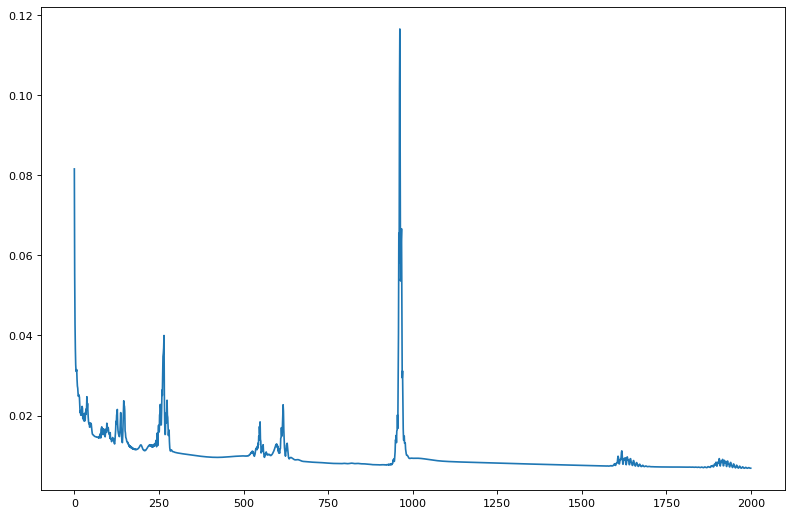

In [19]:
plt.figure(figsize=(12,8), dpi=80)
plt.plot(history3.history['mae'])

**Output is Input with 5 Second Lag**

Input is random Gaussian passed through a LPF. 

First 5 second of output is padded with a random sum of sinusoids

In [32]:
T = 30            # total time
n = 500             # size of the reservoir in the ESN
u4 = 10
tau = 1.0          # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1e0 # Initial learning rate for RLS
dtdivtau = dt / tau

 

In [33]:
def f(x, n):
    y = 0
    for i in range(n):
      tau = np.random.uniform(low=0, high=i*5+1)
      y += np.sin(tau*x)
    return y / np.max(np.abs(y),axis=0)

Text(0, 0.5, 'Dimension')

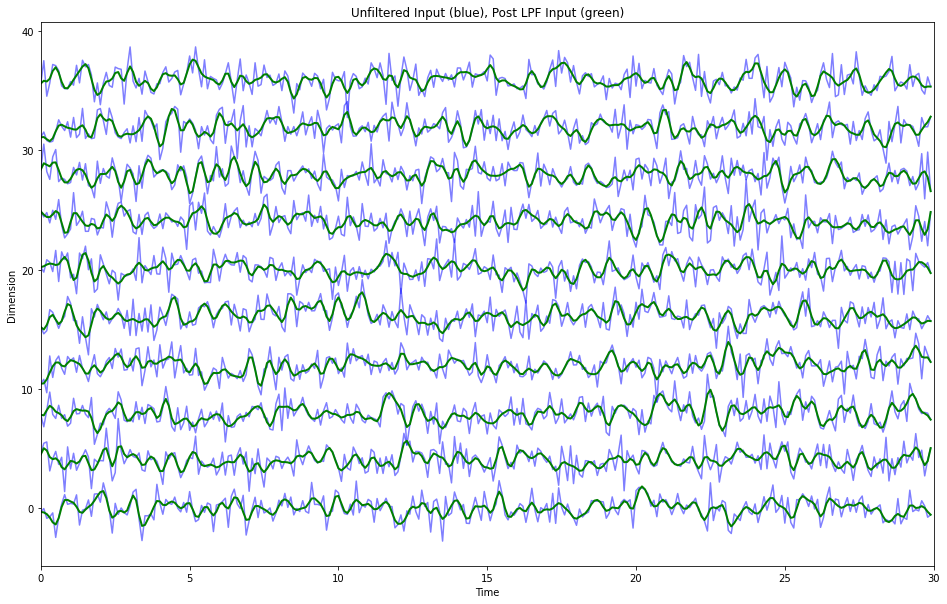

In [34]:
input4 = np.random.multivariate_normal(mean = np.zeros(u4), cov = np.eye(u4), size = ntime) 
input4 = np.float32(input4)
temp = input4.copy()

for i in range(input4.shape[1]):
  input4[:,i] = butter_lowpass_filter(input4[:,i], 6, fs, order)

plt.figure(figsize = (16,10))

plt.plot(time , temp + 4*np.arange(0, temp.shape[1]), 'b',alpha = 0.5);
plt.plot(time , input4  + 4*np.arange(0, input4.shape[1]), 'g', lw = 2) 
plt.xlim((0, T))
plt.title('Unfiltered Input (blue), Post LPF Input (green)')
plt.xlabel('Time')
plt.ylabel('Dimension')

Text(0, 0.5, 'Dimension')

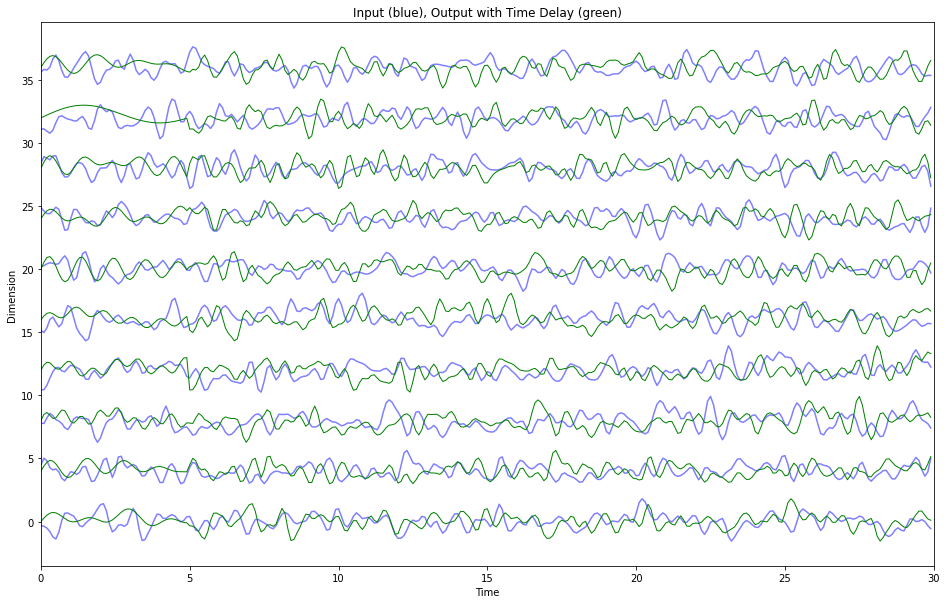

In [35]:
start = 50
out2 = input4[:-start,:].copy()
temp5 = []
for i in range(u4):
  temp5.append(f(time[:start], 3))
temp5 = tf.transpose(tf.convert_to_tensor(temp5,dtype=tf.float32))
out2 = np.concatenate([temp5, out2],axis = 0)


plt.figure(figsize = (16,10))

plt.plot(time , input4 + 4*np.arange(0, input4.shape[1]), 'b',alpha = 0.5);
plt.plot(time , out2  + 4*np.arange(0, out2.shape[1]), 'g', lw = 1) 
plt.xlim((0, T))
plt.title('Input (blue), Output with Time Delay (green)')
plt.xlabel('Time')
plt.ylabel('Dimension')

In [41]:
myesn4 = EchoStateNetwork( dtdivtau= dtdivtau, units = n, output_size = out2.shape[1], activation = 'tanh' )
model4 = FORCEModel(myesn4, return_sequences=True)  
model4.compile(metrics=["mae"] )

In [42]:
history4 = model4.fit(x=input4, y= out2, epochs =5000)

Streaming output truncated to the last 5000 lines.
Epoch 2501/5000
1/1 [==============================] - 0s 304ms/step - mae: 0.1041
Epoch 2502/5000
1/1 [==============================] - 0s 308ms/step - mae: 0.1019
Epoch 2503/5000
1/1 [==============================] - 0s 305ms/step - mae: 0.1031
Epoch 2504/5000
1/1 [==============================] - 0s 303ms/step - mae: 0.1028
Epoch 2505/5000
1/1 [==============================] - 0s 331ms/step - mae: 0.1028
Epoch 2506/5000
1/1 [==============================] - 0s 299ms/step - mae: 0.1002
Epoch 2507/5000
1/1 [==============================] - 0s 350ms/step - mae: 0.0977
Epoch 2508/5000
1/1 [==============================] - 0s 341ms/step - mae: 0.0978
Epoch 2509/5000
1/1 [==============================] - 0s 327ms/step - mae: 0.1001
Epoch 2510/5000
1/1 [==============================] - 0s 301ms/step - mae: 0.1043
Epoch 2511/5000
1/1 [==============================] - 0s 315ms/step - mae: 0.1084
Epoch 2512/5000
1/1 [===============

In [43]:
z_t_call_4 = model4.predict(input4)

Text(0, 0.5, 'Dimension')

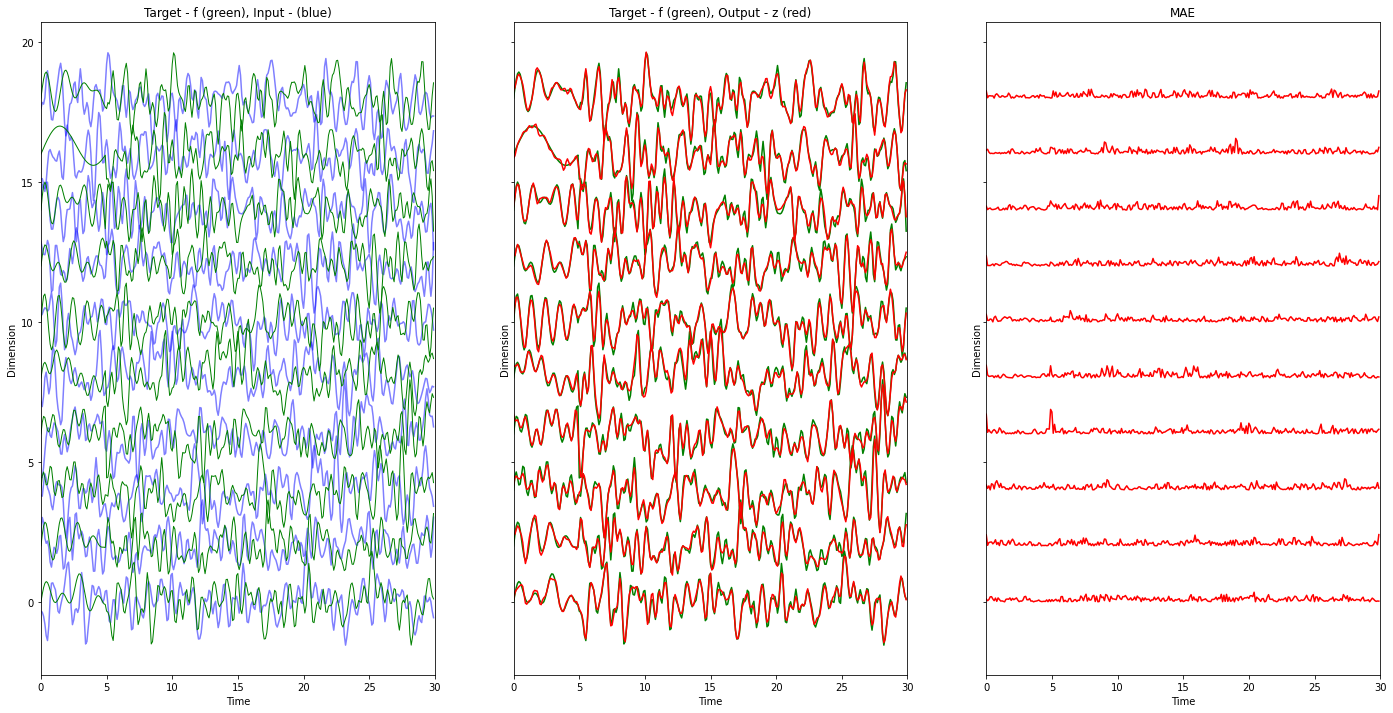

In [44]:
 fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey = True, figsize=(24,12))


ax0.plot(time , input4 + 2*np.arange(0, input4.shape[1]), 'b',alpha = 0.5);
ax0.plot(time , out2  + 2*np.arange(0, out2.shape[1]), 'g', lw = 1) 
ax0.set_xlim((0, T))
ax0.set_title('Target - f (green), Input - (blue)')
ax0.set_xlabel('Time')
ax0.set_ylabel('Dimension')


ax1.plot(time , out2  + 2*np.arange(0, out2.shape[1]), 'g')
ax1.plot(time , z_t_call_4 + 2*np.arange(0, z_t_call_4.shape[1]), 'r');
 
ax1.set_xlim((0, T))
ax1.set_title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(out2-z_t_call_4) + 2*np.arange(0, z_t_call_4.shape[1]), 'r');
ax2.set_xlim((0, T))
ax2.set_title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

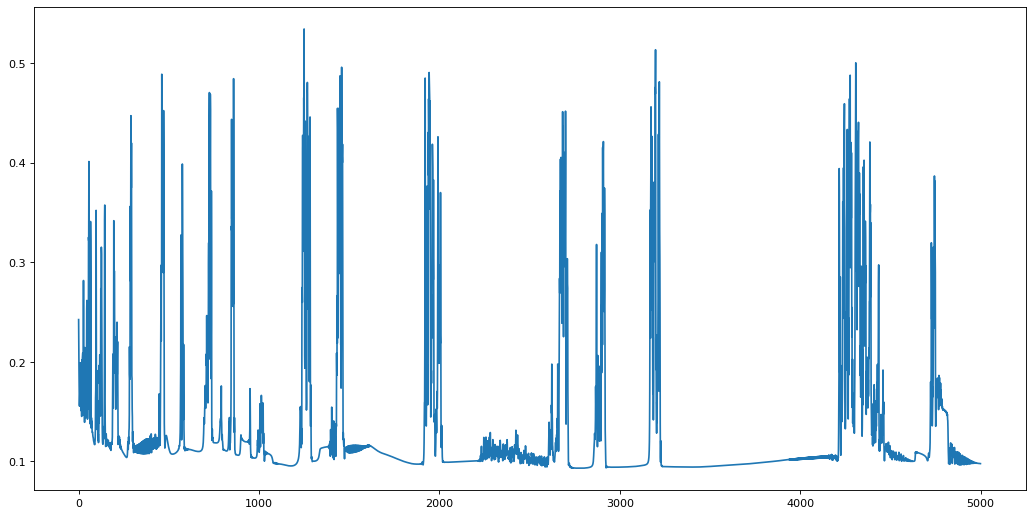

In [45]:
plt.figure(figsize=(16,8), dpi=80)
plt.plot(history4.history['mae'])